# Assignment 1

This assignment provides a brief introduction to the machine learning process that we will cover in depth in this course. We want to show a simple workflow of how you can use the sklearn library for machine learning. We will be using the MNIST handwritten digits dataset to dive into the machine learning process.

## Imports

First let us import some libraries.

1) numpy - http://www.numpy.org/ - A library for dealing with N-dimensional arrays in python. Numpy provides efficient implementations of common numerical computations used in linear algebra.

2) sklearn - https://scikit-learn.org/stable/ - A data analysis library that provides implementations of many machine learning algorithms (and much more!).

3) matplotlib - https://matplotlib.org/ - A python 2D plotting library used for visualizations (data, charts, etc.)

These libraries (and many more) are often used together and built on top of each other. For example, sklearn depends on numpy and uses numpy arrays under the hood.

In [70]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import io
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

For this homework assignment, we will be using the MNIST dataset. The MNIST data is a collection of black and white 28x28 images, each picturing a handwritten digit. These were collected from digits people write at the post office, and now this dataset is a standard benchmark to evaluate models against used in the machine learning community. We have provided the .mat file in the assignment repository.

In [71]:
mnist = io.loadmat('mnist-original.mat', struct_as_record=True)
X = mnist['data'].astype('float64').T # Transpose the matrix because we want each row to be an example
y = mnist['label'].astype('int64').T

## Data Exploration

Let us first explore this data a little bit.

In [72]:
print(X.shape, y.shape) 

(70000, 784) (70000, 1)


The X matrix here contains all the digit pictures. The data is (n_samples x n_features), meaning this data contains 70000 pictures, each with 784 features (the 28x28 image is flattened into a single row). The y vector contains the label for each digit, so we know which digit (or class - class means category) is in each picture.

Let's try and visualize this data a bit. Change around the index variable to explore more.

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

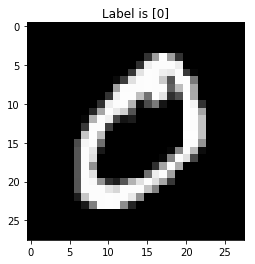

In [76]:
index = 0 #15000, 28999, 67345
image = X[index].reshape((28, 28))
print(image) # Shows the pixel values at each cell in the matrix. Ranges from 0-255
plt.title('Label is ' + str(y[index]))
plt.imshow(image, cmap='gray')

Notice that each pixel value ranges from 0-255. When we train our models, a good practice is to *standardize* the data so different features can be compared more equally (it also speeds up computation). Here we will use a simple standardization, squeezing all values into the [0, 1] interval range. This kind of standardization is called min-max normalization. For other methods, see https://en.wikipedia.org/wiki/Feature_scaling

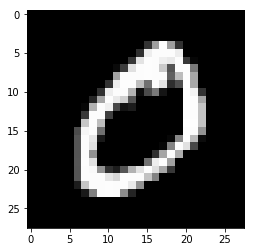

In [77]:
X = X / 255
plt.imshow(image, cmap='gray')# Shorthand for dividing all values in the X matrix by 255. Numpy provides lots of shortcuts like this.

When we train our model, we want it to have the lowest error. Error presents itself in 2 ways: bias (how close our model is to the ideal model), and variance (how much our model varies with different datasets). If we train our model on a chunk of data, and then test our model on that same data, we will only witness the first type of error - bias. However, if we test on new, unseen data, that will reflect both bias and variance. This is the reasoning behind cross validation.

So, we want to have 2 datasets, train and test, each used for the named purpose exclusively.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [79]:
print(X_train.shape, X_test.shape)

(52500, 784) (17500, 784)


## Applying Models

Now we will walk you through applying various models to try and achieve the lowest error rate on this data.

Each of our labels is a number from 0-9. That is, our labels are categorical. If we simply did regression on this data, the labels would imply some sort of ordering and distance between the classes (imagine we were classing colors instead, there is no notion of distance or order i.e. 8 is not "more" of a digit than 7). We can fix this issue by one-hot encoding our labels. So, instead of each label being a simple digit, each label is a vector of 10 entries. 9 of those entries are zero, and only 1 entry is equal to one, corresponding to the index of the digit. This way, the distance between the labels are the same.

In [80]:
enc = OneHotEncoder(sparse=False)
y_hot = enc.fit_transform(y.reshape(-1, 1))
y_train_hot = enc.transform(y_train.reshape(-1, 1))
y_hot.shape

/Users/jaya.bonelli/mais-bootcamp-w2019/.mais-env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(70000, 10)

Remember how the first sample is the digit zero? Let's now look at the new label at that index.

In [81]:
y_hot[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Linear Regression

There are 3 steps to build your model: 

1) Create the model

2) Train the model

3) Use your model to make predictions

In the sklearn API, this is made very clear. First you instantiate the model (constructor), then you call train it with the `fit` method, then you can make predictions on new data with the `test` method.

First, let's do a basic linear regression.

In [82]:
# Instantiate the model
linear = LinearRegression()
# Fit the model (train)
linear.fit(X_train, y_train_hot)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [83]:
# use trained model to predict both train and test sets
y_train_pred = linear.predict(X_train)
y_test_pred = linear.predict(X_test)

# print accuracies
print('train acc: ', accuracy_score(y_train_pred.argmax(axis=1), y_train))
print('test acc: ', accuracy_score(y_test_pred.argmax(axis=1), y_test))

train acc:  0.8588380952380953
test acc:  0.8551428571428571


Note on interpretability: you can view the weights of your model with `linear.coef_`

### Ridge Regression

Ridge Regression (L2) is one method of preventing a common problem in machine learning called "overfitting". Remember when we split our examples into training and test sets? Overfitting occurs when the model performs well on the training set but not on the test set. This means that the model does not generalize well to previously unseen examples.

Let us try Ridge Regression and see if we get better results

In [84]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train_hot)
print('train acc: ', accuracy_score(ridge.predict(X_train).argmax(axis=1), y_train))
print('test acc: ', accuracy_score(ridge.predict(X_test).argmax(axis=1), y_test))

train acc:  0.8514666666666667
test acc:  0.8573142857142857


The alpha controls how much to penalize the weights. Play around with it to see if you can improve the test accuracy.

Now you have seen how to use some basic models to fit and evaluate your data. You will now walk through working with more models. Fill in code where needed.

### Logistic Regression

We will now do logistic regression. From now on, the models will automatically one-hot the labels (so we don't need to worry about it).

In [89]:
logreg = LogisticRegression(C=0.01, multi_class='multinomial', solver='saga', tol=0.1)
logreg.fit(X_train, y_train)
print('train acc: ', accuracy_score(logreg.predict(X_train), y_train))
print('test acc: ', accuracy_score(logreg.predict(X_test), y_test))

/Users/jaya.bonelli/mais-bootcamp-w2019/.mais-env/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train acc:  0.10146666666666666
test acc:  0.10365714285714285


Our accuracy has jumped ~5%! Why is this? Logistic Regression is a more complex model - instead of computing raw scores as in linear regression, it does one extra step and squashes values between 0 and 1. This means our model now optimizes over *probabilities* instead of raw scores. This makes sense since our vectors are 1-hot encoded.

The C hyperparameter controls inverse regularization strength (inverse for this model only). Reguralization is important to make sure our model doesn't overfit (perform much better on train data than test data). Play around with the C parameter to try and get better results! You should be able to hit 92%.

### Question 1) Random Forest

Decision Trees are a completely different type of classifier. They essentially break up the possible space by repeatedly "splitting" on features to keep narrowing down the possibilities. Decision Trees are normally individually very week, so we typically average them together in bunches called Random Forest.

Now you have seen many examples for how to construct, fit, and evaluate a model. Now do the same for Random Forest using the [documentation here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). You should be able to create one easily without needing to specify any constructor parameters.

In [102]:
forest = RandomForestClassifier(n_estimators = 300, min_samples_split = 3, max_features="log2")
forest.fit(X_train, y_train)
print('train accuracy: ', accuracy_score(forest.predict(X_train), y_train))
print('test accuracy: ', accuracy_score(forest.predict(X_test), y_test))

/Users/jaya.bonelli/mais-bootcamp-w2019/.mais-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


train accuracy:  1.0
test accuracy:  0.9706285714285714


That train accuracy is amazing, let's see if we can boost up the test accuracy a bit (since that's what really counts). Try and play around with the hyperparameters to see if you can edge out more accuracy (look at the documentation for parameters in the constructor). Focus on `n_estimators`, `min_samples_split`, `max_features`. You should be able to hit ~97%.

### SVC

A support vector classifier is another completely different type of classifier. It tries to find the best separating hyperplane through your data.

The SVC will toast our laptops unless we reduce the data dimensionality. Let's keep 80% of the variation, and get rid of the rest. (This will cause a slight drop in performance, but not by much).

In [112]:
pca = PCA(n_components=0.8, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Great! Now let's take a look at what that actually did.

In [111]:
X_train_pca.shape

(52500, 43)

Remember, before we had 784 (28x28) features! However, PCA found just 43 basis features that explain 80% of the data. So, we went to just 5% of the original input space, but we still retained 80% of the information! Nice.

This [blog post](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) explains dimensionality reduction with MNIST quite well. It's a short read (<10 mins), and it contains some pretty cool visualizations.

Now let's train our first SVC. The LinearSVC can only find a linear decision boundary (the hyperplane).

In [113]:
lsvc = LinearSVC(dual=False, tol=0.01)
lsvc.fit(X_train_pca, y_train)
print('train acc: ', accuracy_score(lsvc.predict(X_train_pca), y_train))
print('test acc: ', accuracy_score(lsvc.predict(X_test_pca), y_test))

/Users/jaya.bonelli/mais-bootcamp-w2019/.mais-env/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train acc:  0.8922476190476191
test acc:  0.8929142857142857


SVMs are really interesting because they have something called the *dual formulation*, in which the computation is expressed as training point inner products. This means that data can be lifted into higher dimensions easily with this "kernel trick". Data that is not linearly separable in a lower dimension can be linearly separable in a higher dimension - which is why we conduct the transform. Let us experiment.

A transformation that lifts the data into a higher-dimensional space is called a *kernel*. A polynomial kernel expands the feature space by computing all the polynomial cross terms to a specific degree.

### Question 2) Poly SVC

In [ ]:
psvc = SVC(kernel='poly', degree=3, tol=0.01, cache_size=4000)
psvc.fit(X_train_pca,y_train)
print('train acc:', accuracy_score(psvc.predict(X_train_pca), y_train))
print('test acc:', accuracy_score(psvc.predict(X_test_pca), y_test))

Play around with the degree of the polynomial kernel to see what accuracy you can get.

### Question 3) RBF SVC

The RBF kernel uses the gaussian function to create an infinite dimensional space - a gaussian peak at each datapoint. Now fiddle with the `C` and `gamma` parameters of the gaussian kernel below to see what you can get. [Here's documentation](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [ ]:
rsvc = SVC(kernel='rbf', tol=0.01, cache_size=4000)
rsvc.fit(X_train_pca,y_train)
print('train acc:', accuracy_score(rsvc.predict(X_train_pca), y_train))
print('test acc:', accuracy_score(rsvc.predict(X_test_pca), y_test))

Isn't that just amazing accuracy?

## Basic Neural Network

You should never do neural networks in sklearn. Use Pytorch, Keras, etc. However, we will use sklearn for demonstrative purposes.

Basic neural networks proceed in layers. Each layer has a certain number of nodes, representing how expressive that layer can be. Below is a sample network, with an input layer, one hidden (middle) layer of 50 neurons, and finally the output layer.

### Question 4) Neural Network

In [ ]:
nn = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', verbose=1)
nn.fit(X_train,y_train)
print('train acc:', accuracy_score(nn.predict(X_train), y_train))
print('test acc:', accuracy_score(nn.predict(X_test), y_test))

/Users/jaya.bonelli/mais-bootcamp-w2019/.mais-env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 2.23150311
Iteration 2, loss = 1.87045858
Iteration 3, loss = 1.40338183
Iteration 4, loss = 1.07754895
Iteration 5, loss = 0.87168316
Iteration 6, loss = 0.73627166
Iteration 7, loss = 0.64274142
Iteration 8, loss = 0.57605371
Iteration 9, loss = 0.52687113
Iteration 10, loss = 0.48977475
Iteration 11, loss = 0.46096207
Iteration 12, loss = 0.43822767
Iteration 13, loss = 0.42014262
Iteration 14, loss = 0.40512186
Iteration 15, loss = 0.39279077
Iteration 16, loss = 0.38224981
Iteration 17, loss = 0.37324749
Iteration 18, loss = 0.36563236
Iteration 19, loss = 0.35874998
Iteration 20, loss = 0.35275154
Iteration 21, loss = 0.34748403
Iteration 22, loss = 0.34270783
Iteration 23, loss = 0.33826940
Iteration 24, loss = 0.33444177
Iteration 25, loss = 0.33081656
Iteration 26, loss = 0.32741138
Iteration 27, loss = 0.32430241
Iteration 28, loss = 0.32139756
Iteration 29, loss = 0.31858862
Iteration 30, loss = 0.31611886
Iteration 31, loss = 0.31364870
Iteration 32, los

Fiddle around with the hiddle layers. Change the number of neurons, add more layers, experiment. You should be able to hit 98% accuracy.

Neural networks are optimized with a technique called gradient descent (a neural net is just one big function - so we can take the gradient with respect to all its parameters, then just go opposite the gradient to try and find the minimum). This is why it requires many iterations to converge.

## Turning In

1. Convert this notebook to a regular python file (file -> download as -> python)

2. Submit both the notebook and python file via a pull request as specified in the README